In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
from symbol import get_resnet_model
from symbol import YOLO_loss
from data_ulti import get_iterator

In [2]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    return [cxt, cyt, wt, ht]

def bboxdraw(img, label, dscale=32):
    assert label.shape == (7,7,5)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.2)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h = label[i,j,1:]
        cxt, cyt, wt ,ht = decodeBox([i, j, cx,cy,w,h], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
        plt.plot(int(cxt), int(cyt), '*')
    plt.show()

In [3]:
data = mx.io.ImageRecordIter(path_imgrec='DATA_rec/cat_small.rec',
                             data_shape=(3,224,224),
                             label_width=7*7*5, 
                             batch_size=1,)

In [4]:
# get sym 
sym, args_params, aux_params = mx.model.load_checkpoint('cat_detect_full_scale', 448)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(data.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=data, num_batch=10)

/home/chuck/DLenv/MXNet/local/lib/python2.7/site-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/home/chuck/DLenv/MXNet/local/lib/python2.7/site-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
data.reset()
batch = data.next()
batch = data.next()
batch = data.next()
img = batch.data[0].asnumpy()[0].transpose((1,2,0))
label = batch.label[0].asnumpy().reshape((7,7,5))
pred = (out.asnumpy()[2]+1)/2
print pred.shape

(7, 7, 5)


Prediction


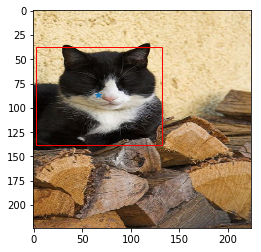

In [6]:
print "Prediction"
bboxdraw(img, pred)

Ground Truth


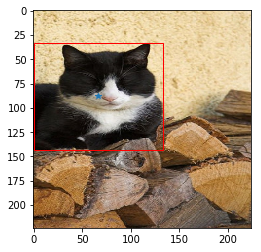

In [7]:
print "Ground Truth"
bboxdraw(img, label)